# Embeddings (Traditional Statistical Vector-based Embeddings)

Yes, traditional statistical vector-based embeddings are foundational techniques in natural language processing (NLP) that represent text data using various statistical measures. Here are some of these traditional methods:

### 1. Bag of Words (BoW)

- **Description**: Represents text by the occurrence (count) of each word in the document without considering the word order or context.
- **Implementation**: Typically uses a Count Vectorizer.
- **Characteristics**: Produces sparse vectors where each dimension corresponds to a specific term from the vocabulary and the value is the word count.
- **Use Cases**: Simple and effective for basic text classification and clustering tasks.

### 2. Term Frequency-Inverse Document Frequency (TF-IDF)

- **Description**: Enhances the Bag of Words model by weighting terms based on their frequency in a document and their inverse frequency across all documents in the corpus.
- **Implementation**: Uses TF-IDF Vectorizer.
- **Characteristics**: Produces sparse vectors with weighted values, reducing the impact of common words and highlighting important terms.
- **Use Cases**: Widely used in information retrieval and text mining.

### 3. Latent Semantic Analysis (LSA) or Latent Semantic Indexing (LSI)

- **Description**: Applies Singular Value Decomposition (SVD) to the term-document matrix (typically after applying TF-IDF) to reduce dimensions and capture latent semantic relationships between terms.
- **Implementation**: Perform SVD on the term-document matrix.
- **Characteristics**: Transforms high-dimensional sparse vectors into lower-dimensional dense vectors.
- **Use Cases**: Useful for topic modeling and capturing underlying semantic structures.

### 4. Latent Dirichlet Allocation (LDA)

- **Description**: A generative probabilistic model that represents documents as mixtures of topics and topics as mixtures of words.
- **Implementation**: Uses probabilistic algorithms to infer topic distributions.
- **Characteristics**: Produces dense vectors representing the distribution of topics in each document.
- **Use Cases**: Widely used for topic modeling and discovering abstract topics in large text corpora.

### 5. Pointwise Mutual Information (PMI)

- **Description**: Measures the association between a pair of words by comparing the probability of their co-occurrence to the probabilities of their individual occurrences.
- **Implementation**: Uses co-occurrence matrices.
- **Characteristics**: Produces dense vectors that capture the likelihood of words appearing together.
- **Use Cases**: Useful for capturing word associations and semantic relationships.


In [1]:
import ast
import os
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from alive_progress import alive_bar
from scipy.sparse import csr_matrix
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import (
    cosine_similarity,
    euclidean_distances,
    manhattan_distances,
)
from sklearn.pipeline import make_pipeline

In [2]:
statistical_methods = {
    "bow": (CountVectorizer,),
    "tfidf": (TfidfVectorizer,),
    "lsa": (TfidfVectorizer, TruncatedSVD),
    "lda": (CountVectorizer, LatentDirichletAllocation),
}

similarity_metrics = {
    "cosine": cosine_similarity,
    "euclidean": euclidean_distances,
    "dot": np.dot,
    "manhattan": manhattan_distances,
}

In [3]:
# Parameters
CONTRIBUTOR: str = "Health Promotion Board"
CATEGORY: str = "live-healthy"
METHOD: str = "bow"
KWARGS: dict = {"max_features": 384}
METRIC: str = "cosine"

In [4]:
# Parameters
METHOD = "tfidf"
KWARGS = {"max_features": 384}
METRIC = "cosine"

In [5]:
CLEAN_DATA_PATH = os.path.join("..", "data", "healthhub_small_clean")

CLEANED_CHUNK_ID_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_chunk_id_list_small_clean.pkl"
)
CLEANED_SOURCE_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_source_list_small_clean.pkl"
)
CLEANED_DOMAIN_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_domain_list_small_clean.pkl"
)
CLEANED_TITLE_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_title_list_small_clean.pkl"
)
CLEANED_CONTRIBUTOR_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_contributor_list_small_clean.pkl"
)
CLEANED_CONTENT_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_content_list_small_clean.pkl"
)
CLEANED_CATEGORY_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_category_list_small_clean.pkl"
)

OUTPUT_CM_PATH = os.path.join(
    "..",
    "artifacts",
    "outputs",
    f"{METHOD}_{'_'.join([f'{k}_{v}' for k, v in KWARGS.items()])}_{METRIC}_cm.png",
)
OUTPUT_SIM_PATH = os.path.join(
    "..",
    "artifacts",
    "outputs",
    "statistical_vector_based_embeddings_similarity_scores.xlsx",
)

SHEET_NAME = f"{METHOD}_{METRIC}"

## Load Metadata


In [6]:
with open(CLEANED_CHUNK_ID_LIST_PATH, "rb") as file:
    loaded_chunk_id = pickle.load(file)  # list of chunk ids

with open(CLEANED_SOURCE_LIST_PATH, "rb") as file:
    loaded_source = pickle.load(file)  # list of hyperlinks

with open(CLEANED_DOMAIN_LIST_PATH, "rb") as file:
    loaded_domain = pickle.load(file)  # website domain

with open(CLEANED_TITLE_LIST_PATH, "rb") as file:
    loaded_title = pickle.load(file)  # list of titles each chunk belongs to

with open(CLEANED_CONTRIBUTOR_LIST_PATH, "rb") as file:
    loaded_contributor = pickle.load(file)  # list of contributors

with open(CLEANED_CONTENT_LIST_PATH, "rb") as file:
    loaded_content = pickle.load(file)  # list of chunks of contents

with open(CLEANED_CATEGORY_LIST_PATH, "rb") as file:
    loaded_category = pickle.load(file)  # list of categories

## Create Dataframe


In [7]:
df = pd.DataFrame(
    {
        "chunk_id": loaded_chunk_id,
        "doc_source": loaded_source,
        "doc_domain": loaded_domain,
        "doc_title": loaded_title,
        "contributor": loaded_contributor,
        "text": loaded_content,
        "category": loaded_category,
    }
)

df = df[df["contributor"] == CONTRIBUTOR].reset_index(drop=True)
df = df[df["doc_source"].apply(lambda x: x.split("/")[3] == CATEGORY)].reset_index(
    drop=True
)

print(df.shape)
df.head()

(2008, 7)


,chunk_id,doc_source,doc_domain,doc_title,contributor,text,category
0,web_crawl_c3d4d37b-eb92-5349-9d5c-81f2e38e1cfb_1,https://www.healthhub.sg/live-healthy/building...,healthhub.sg,buildingasupportivenetwork,Health Promotion Board,Building Supportive Network Family Friends Hum...,live-healthy
1,web_crawl_c3d4d37b-eb92-5349-9d5c-81f2e38e1cfb_2,https://www.healthhub.sg/live-healthy/building...,healthhub.sg,buildingasupportivenetwork,Health Promotion Board,"Therefore , advisable number strong relationsh...",live-healthy
2,web_crawl_c3d4d37b-eb92-5349-9d5c-81f2e38e1cfb_3,https://www.healthhub.sg/live-healthy/building...,healthhub.sg,buildingasupportivenetwork,Health Promotion Board,Pick new hobby get know like-minded people enj...,live-healthy
3,web_crawl_2b12fdec-76a5-55a7-ad1e-d0ae2b29c864_1,https://www.healthhub.sg/live-healthy/mental_h...,healthhub.sg,mental_health_emotional_intelligence_pdf,Health Promotion Board,Develop Emotional Intelligence Give Mental Wel...,live-healthy
4,web_crawl_2b12fdec-76a5-55a7-ad1e-d0ae2b29c864_2,https://www.healthhub.sg/live-healthy/mental_h...,healthhub.sg,mental_health_emotional_intelligence_pdf,Health Promotion Board,Learn recognise early signs stress different e...,live-healthy


## Combine Chunks into Single Articles


In [8]:
df["combined_text"] = None

with alive_bar(df["doc_source"].nunique(), force_tty=True) as bar:
    for source in df["doc_source"].unique():
        combined_text = " ".join(df.query("doc_source == @source")["text"].values)
        indices = df.query("doc_source == @source").index.values
        df.loc[indices, "combined_text"] = combined_text
        bar()

# After combining chunks one article, remove all duplicate articles
df = df[~df["doc_source"].duplicated()].reset_index(drop=True)
df["chunk_id"] = df["chunk_id"].apply(lambda x: "_".join(x.split("_")[:-1]))

df


|                                        | ▁▃▅ 0/588 [0%] in 0s (~0s, 0.0/s) 


|███████████████▌                        | ▂▄▆ 228/588 [39%] in 0s (~0s, 859.8/s


|██████████████████▉                     | ▃▅▇ 277/588 [47%] in 0s (~0s, 860.4/s


|████████████████████████▎               | ▄▆█ 356/588 [61%] in 0s (~0s, 862.3/s


|██████████████████████████████▊         | ▅▇▇ 452/588 [77%] in 1s (~0s, 864.8/s


|████████████████████████████████████████| 588/588 [100%] in 0.7s (868.09/s)    

,chunk_id,doc_source,doc_domain,doc_title,contributor,text,category,combined_text
0,web_crawl_c3d4d37b-eb92-5349-9d5c-81f2e38e1cfb,https://www.healthhub.sg/live-healthy/building...,healthhub.sg,buildingasupportivenetwork,Health Promotion Board,Building Supportive Network Family Friends Hum...,live-healthy,Building Supportive Network Family Friends Hum...
1,web_crawl_2b12fdec-76a5-55a7-ad1e-d0ae2b29c864,https://www.healthhub.sg/live-healthy/mental_h...,healthhub.sg,mental_health_emotional_intelligence_pdf,Health Promotion Board,Develop Emotional Intelligence Give Mental Wel...,live-healthy,Develop Emotional Intelligence Give Mental Wel...
2,web_crawl_5b278435-1c29-53b2-830b-aafd2970dd38,https://www.healthhub.sg/live-healthy/meal-ide...,healthhub.sg,meal-ideas-month-9,Health Promotion Board,Meal Ideas : Month 9 Meal ideas 9-month-old ba...,live-healthy,Meal Ideas : Month 9 Meal ideas 9-month-old ba...
3,web_crawl_fb7167c6-3c24-563c-94fd-eb3c7a5ddb1d,https://www.healthhub.sg/live-healthy/soya_uni...,healthhub.sg,soya_unique_plant_protein,Health Promotion Board,Soya Bean — Unique Plant Protein Soya bean pro...,live-healthy,Soya Bean — Unique Plant Protein Soya bean pro...
4,web_crawl_d10afa2b-f15e-5f7d-afd6-484d90f7121b,https://www.healthhub.sg/live-healthy/nutritio...,healthhub.sg,nutrition-for-preschoolers-61-72-months,Health Promotion Board,Nutrition Pre-Schoolers ( Months 61-72 ) guide...,live-healthy,Nutrition Pre-Schoolers ( Months 61-72 ) guide...
...,...,...,...,...,...,...,...,...
583,web_crawl_2c6eb646-9d49-50a3-a419-4443f4a79dfa,https://www.healthhub.sg/live-healthy/slip-ups...,healthhub.sg,slip-ups-dos-and-donts,Health Promotion Board,Slip-Ups : Dos Dont 's Slipped picked cigarett...,live-healthy,Slip-Ups : Dos Dont 's Slipped picked cigarett...
584,web_crawl_d5a43397-6dc5-5162-bbe5-244de8e7773f,https://www.healthhub.sg/live-healthy/is-my-ba...,healthhub.sg,is-my-baby%27s-spit-up-normal,Health Promotion Board,Q & : Baby 's Spit-Up Normal ? Find baby spits...,live-healthy,Q & : Baby 's Spit-Up Normal ? Find baby spits...
585,web_crawl_7aec5e06-ea47-5f02-9fec-0ac89f36aa7a,https://www.healthhub.sg/live-healthy/awkward_...,healthhub.sg,awkward_turtle,Health Promotion Board,Make Friends Better Mental Well-being Overcome...,live-healthy,Make Friends Better Mental Well-being Overcome...
586,web_crawl_49964963-3f83-5d82-9495-b130cc1e629f,https://www.healthhub.sg/live-healthy/what-a-w...,healthhub.sg,what-a-weaning-baby-needs-for-strong-immunity,Health Promotion Board,Weaning Baby Needs Strong Immunity baby reache...,live-healthy,Weaning Baby Needs Strong Immunity baby reache...


## Load Ground Truth Dataframe


In [9]:
ground_df = pd.read_excel(
    os.path.join(
        "..", "data", "Synapxe Content Prioritisation - Live Healthy_020724.xlsx"
    ),
    sheet_name="All Live Healthy",
    index_col=False,
)

ground_truth_col = "Combine Group ID"

ground_df = ground_df[ground_df[ground_truth_col].notna()].reset_index(drop=True)
ground_df[ground_truth_col] = ground_df[ground_truth_col].astype(int)

# Merge dfs so we can get the document title and content
merge_df = pd.merge(ground_df, df, how="inner", left_on="URL", right_on="doc_source")

col_of_int = ["Combine Group ID", "Page Title", "Meta Description", *df.columns]
final_df = merge_df[col_of_int]

print(final_df.shape)
final_df.head()

(187, 11)


,Combine Group ID,Page Title,Meta Description,chunk_id,doc_source,doc_domain,doc_title,contributor,text,category,combined_text
0,1,Getting ready for solids,You have breastfed your baby for 6 months and ...,web_crawl_d94a2444-07ef-5a9a-8929-db35c7844303,https://www.healthhub.sg/live-healthy/baby-get...,healthhub.sg,baby-getting-ready-for-solids,Health Promotion Board,Getting ready solids breastfed baby 6 months w...,live-healthy,Getting ready solids breastfed baby 6 months w...
1,1,Getting Your Baby Started on Solids,"Your baby has reached the 6-month mark, and yo...",web_crawl_b386cb40-ea43-5467-b40e-dff45bcf5a69,https://www.healthhub.sg/live-healthy/getting-...,healthhub.sg,getting-baby-started-on-solids,Health Promotion Board,Getting Baby Started Solids baby reached 6-mon...,live-healthy,Getting Baby Started Solids baby reached 6-mon...
2,1,Feeding Your Baby Solid Food: Baby's First Foo...,"At six months of age, your baby will soon be r...",web_crawl_8c111fe7-a8e1-579e-bf15-b726950b181d,https://www.healthhub.sg/live-healthy/babys_fi...,healthhub.sg,babys_first_food_journey,Health Promotion Board,Feeding Baby Solid Food : Baby 's First Food J...,live-healthy,Feeding Baby Solid Food : Baby 's First Food J...
3,1,"Ready, Steady, Wean! Why, When and How to Move...",Breast milk provides all the nourishment your ...,web_crawl_51124591-ac9f-5670-b05b-45d0d4352e08,https://www.healthhub.sg/live-healthy/ready-st...,healthhub.sg,Ready-Steady-Wean-How-To-Move-Baby-Onto-Solids,Health Promotion Board,"Ready , Steady , Wean ! , Move Baby onto Solid...",live-healthy,"Ready , Steady , Wean ! , Move Baby onto Solid..."
4,1,What A Weaning Baby Needs For Strong Immunity,"When your baby reaches 6 months of age, you ca...",web_crawl_49964963-3f83-5d82-9495-b130cc1e629f,https://www.healthhub.sg/live-healthy/what-a-w...,healthhub.sg,what-a-weaning-baby-needs-for-strong-immunity,Health Promotion Board,Weaning Baby Needs Strong Immunity baby reache...,live-healthy,Weaning Baby Needs Strong Immunity baby reache...


In [10]:
def generate_statistical_embeddings(
    corpus: list[str], method: str, **kwargs: dict
) -> tuple[csr_matrix, pd.DataFrame] | tuple[np.ndarray, None]:
    components = statistical_methods.get(method, None)

    df = None

    if len(components) == 1 and components is not None:
        vectorizer = components[0](**kwargs)
        print(vectorizer)
        X = vectorizer.fit_transform(corpus)

        # Get words from stopwords array to use as headers
        feature_names = vectorizer.get_feature_names_out()
        # Combine header titles and weights
        df = pd.DataFrame(X.toarray(), columns=feature_names)

    elif len(components) > 1 and components is not None:
        pipeline = make_pipeline(components[0](), components[1](**kwargs))
        print(pipeline)
        X = pipeline.fit_transform(corpus)

    return X, df

In [11]:
X, mat_df = generate_statistical_embeddings(
    final_df["combined_text"].to_list(), method=METHOD, **KWARGS
)

print(X.shape)  # (num_docs, emb_dim)
if mat_df is not None:
    # ruff: noqa: F821
    display(mat_df.head(7))

TfidfVectorizer(max_features=384)
(187, 384)


,10,12,20,2016,30,able,active,activities,activity,add,...,within,without,work,workout,worth,would,www,year,years,young
0,0.055499,0.074914,0.0,0.000000,0.0,0.015439,0.0,0.0,0.000000,0.015860,...,0.000000,0.013875,0.013262,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.047750,0.075197,0.0,0.000000,0.0,0.008856,0.0,0.0,0.000000,0.027292,...,0.000000,0.007958,0.015214,0.0,0.0,0.008779,0.000000,0.009446,0.000000,0.000000
2,0.012471,0.016833,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.071277,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.028775,0.000000
3,0.000000,0.000000,0.0,0.000000,0.0,0.057740,0.0,0.0,0.000000,0.000000,...,0.000000,0.025945,0.000000,0.0,0.0,0.000000,0.000000,0.061588,0.000000,0.000000
4,0.000000,0.107138,0.0,0.000000,0.0,0.000000,0.0,0.0,0.037116,0.000000,...,0.047565,0.000000,0.018967,0.0,0.0,0.109440,0.025866,0.000000,0.045785,0.047565
5,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.283931,0.000000,0.000000
6,0.000000,0.000000,0.0,0.033736,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.029717,0.000000,0.000000,0.000000


In [12]:
# Compute similarity matrix
similarity_metric = similarity_metrics[METRIC]

if METRIC == "dot":
    similarities = X @ X.T
    if type(similarities) != np.ndarray:
        similarities = similarities.toarray()
elif METRIC in ["euclidean", "manhattan"]:
    distances = similarity_metric(X, X)
    similarities = 1 / (
        1 + distances
    )  # https://stats.stackexchange.com/questions/158279/how-i-can-convert-distance-euclidean-to-similarity-score#:~:text=If,is%20commonly%20used.
else:
    similarities = similarity_metric(X, X)

print(similarities.shape)  # (num_docs, num_docs)

(187, 187)


In [ ]:
if METHOD == "bow" and METRIC == "dot":
    similarities = np.divide(similarities, similarities.max(), casting="same_kind")

In [13]:
# Function to darken a hex color


def darken_hex_color(hex_color, factor=0.7):
    # Ensure factor is between 0 and 1
    factor = max(0, min(1, factor))

    # Convert hex color to RGB
    r = int(hex_color[1:3], 16)
    g = int(hex_color[3:5], 16)
    b = int(hex_color[5:7], 16)

    # Darken the color
    r = int(r * factor)
    g = int(g * factor)
    b = int(b * factor)

    # Convert RGB back to hex
    darkened_color = f"#{r:02x}{g:02x}{b:02x}".upper()

    return darkened_color

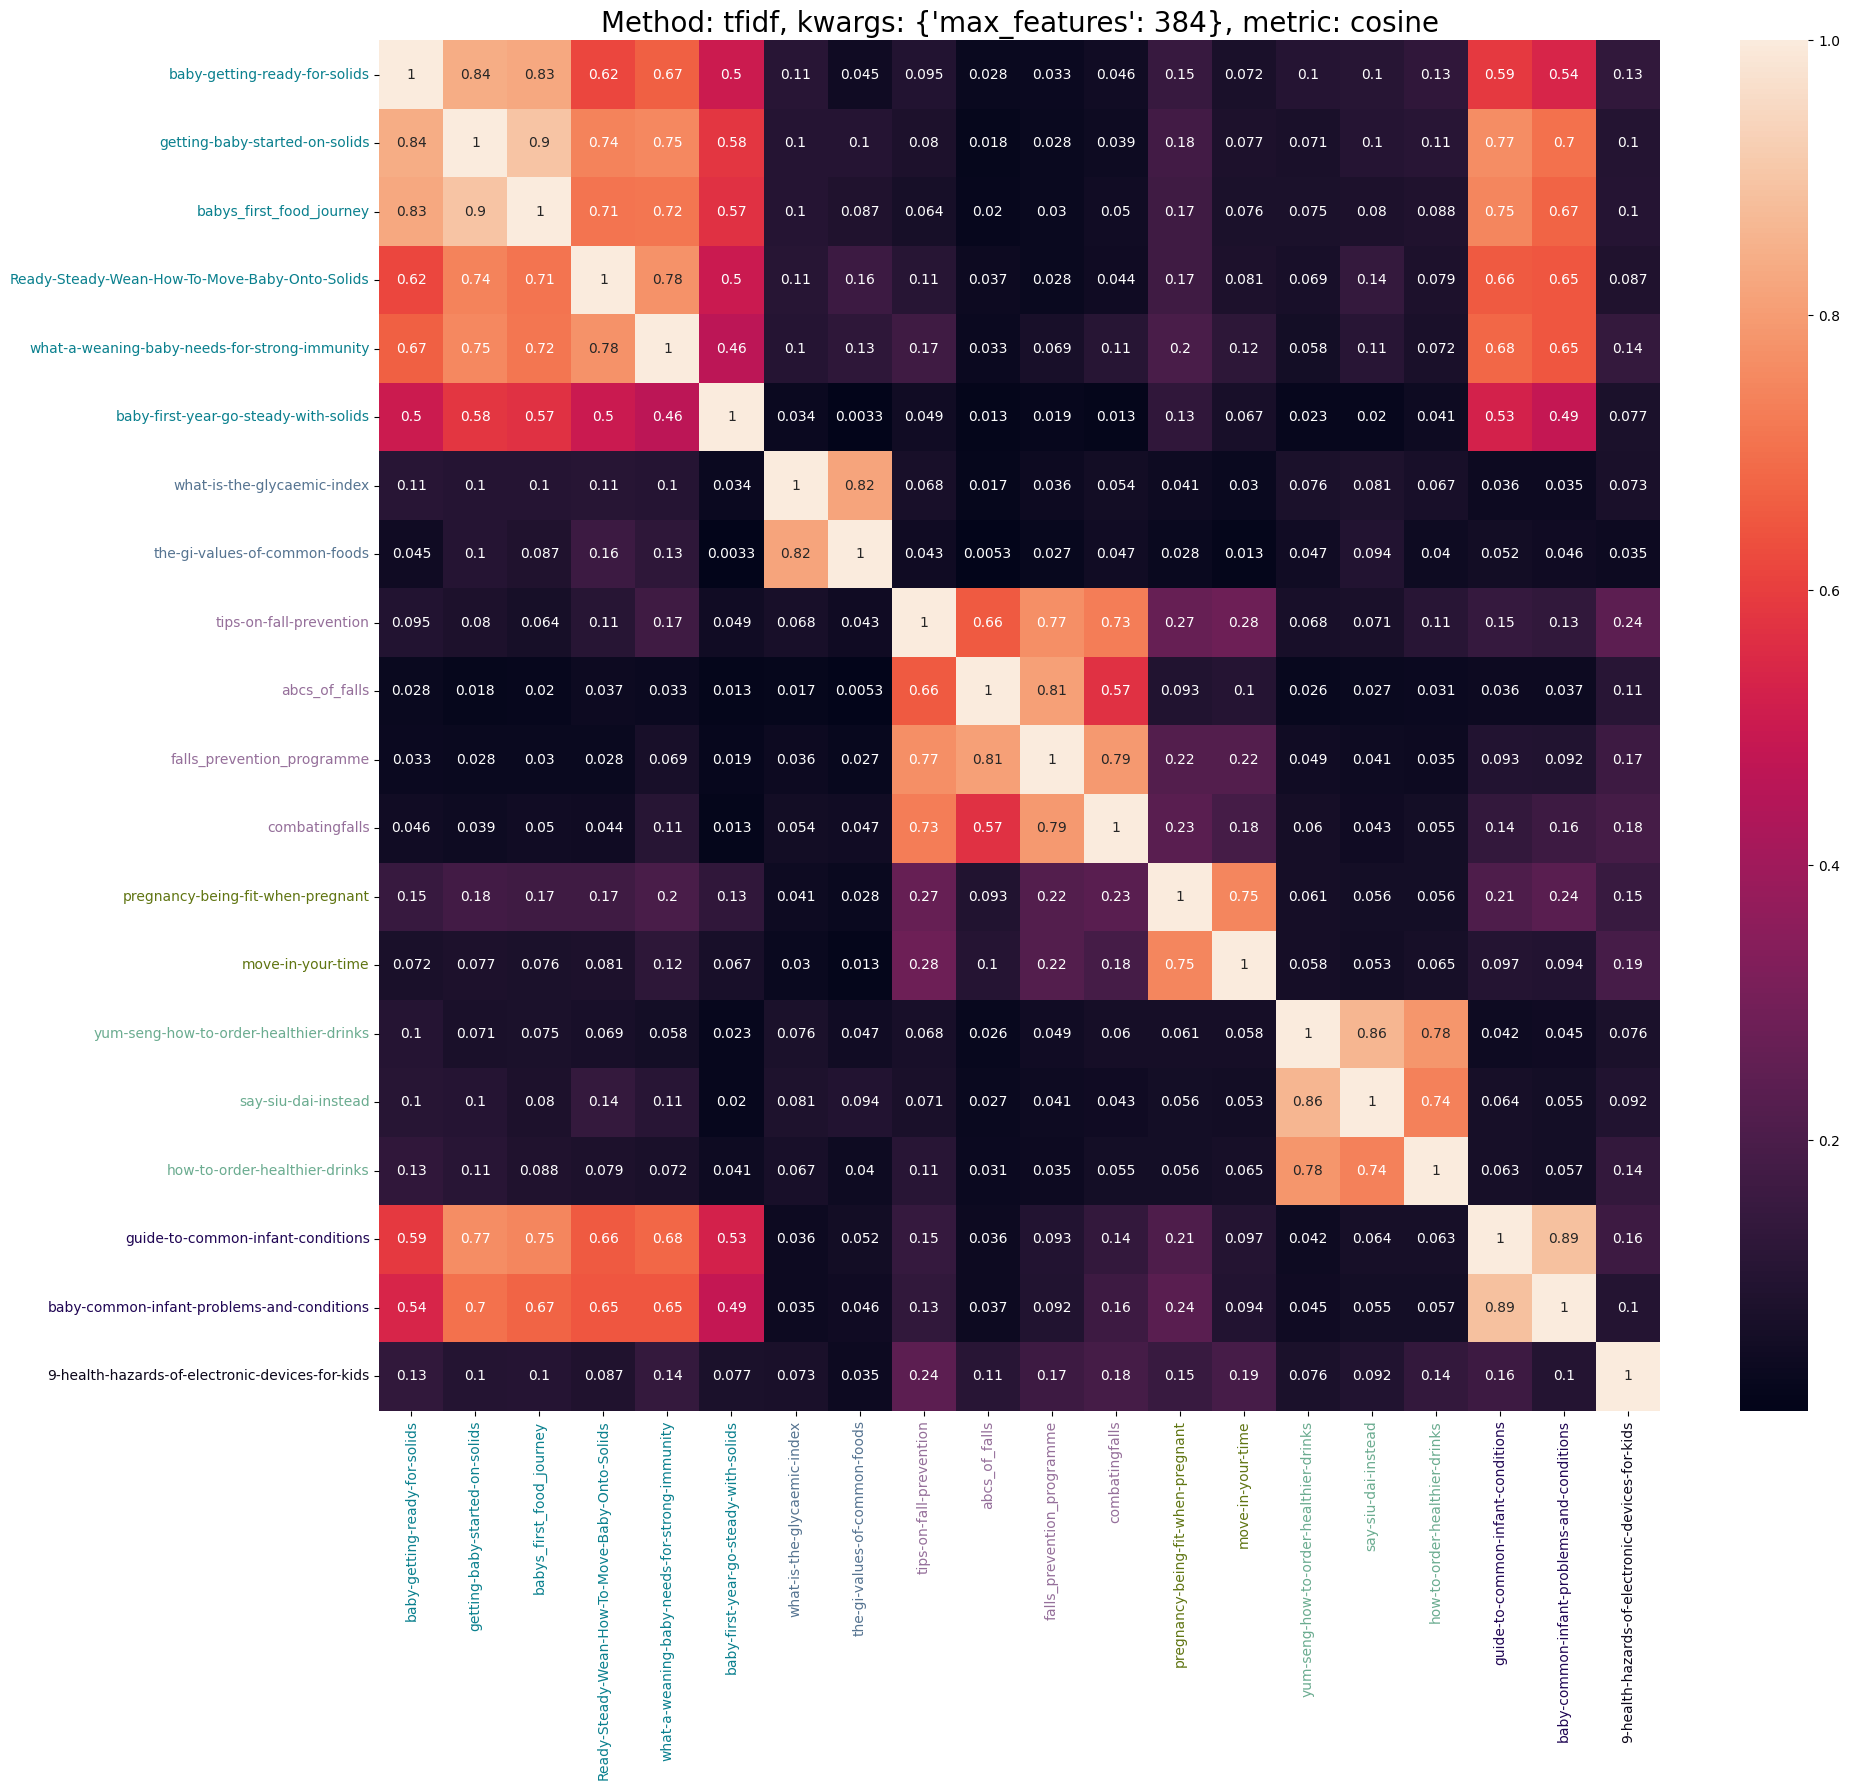

In [14]:
article_titles = final_df.loc[:, "doc_title"].tolist()

start = 0
end = 20

cutoff_similarities = similarities[start:end, start:end]
cutoff_article_titles = article_titles[start:end]

# Generate random colours
hexadecimal_alphabets = "0123456789ABCDEF"
ground_truth_cluster_ids = final_df.iloc[start:end]["Combine Group ID"].unique()
colours = {
    id: darken_hex_color(
        "#" + "".join([random.choice(hexadecimal_alphabets) for _ in range(6)])
    )
    for id in ground_truth_cluster_ids
}


plt.subplots(figsize=(20, 18))
ax = sns.heatmap(
    cutoff_similarities,
    xticklabels=cutoff_article_titles,
    yticklabels=cutoff_article_titles,
    annot=True,
    fmt=".2g",
)

for x_tick_label, y_tick_label in zip(
    ax.axes.get_xticklabels(), ax.axes.get_yticklabels()
):

    ground_truth_cluster_id = (
        final_df[final_df["doc_title"] == y_tick_label.get_text()]["Combine Group ID"]
        .values[0]
        .astype(int)
    )
    colour = colours[ground_truth_cluster_id]
    y_tick_label.set_color(colour)
    x_tick_label.set_color(colour)

ax.set_title(f"Method: {METHOD}, kwargs: {KWARGS}, metric: {METRIC}", fontsize=20)
plt.tight_layout()
plt.show()

In [15]:
ax.figure.savefig(OUTPUT_CM_PATH, dpi=400)

## Save Similarity Scores


In [16]:
sim_df = pd.DataFrame(similarities)

sim_df.index = merge_df["Page Title"]
sim_df.columns = merge_df["Page Title"]

# Store kwwargs as index name
sim_df.index.name = str(KWARGS)
sim_df.columns.name = None

In [17]:
if os.path.isfile(OUTPUT_SIM_PATH):
    with pd.ExcelWriter(
        OUTPUT_SIM_PATH, mode="a", engine="openpyxl", if_sheet_exists="replace"
    ) as writer:  # Open with pd.ExcelWriter
        sim_df.to_excel(writer, sheet_name=SHEET_NAME)
else:
    sim_df.to_excel(OUTPUT_SIM_PATH, sheet_name=SHEET_NAME)

In [18]:
file = pd.ExcelFile(OUTPUT_SIM_PATH)
print(file.sheet_names)

['bow_cosine', 'bow_euclidean', 'bow_dot', 'bow_manhattan', 'tfidf_cosine']


In [19]:
tmp = pd.read_excel(OUTPUT_SIM_PATH, sheet_name=SHEET_NAME)
print(ast.literal_eval(tmp.columns[0]))

{'max_features': 384}
